In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import convolve2d, savgol_filter
from PIL import Image
from pointing2d_backfiltlib import filterImage, walkDir, norm_gaus2d_ary
from pointing2d_lib import load_dict_from_file, points_to_roi
import os
import pointing2d_fit as fit
import csv

# GET FILES


In [2]:
folder = "D:\\Bunker C\\2022\\Dec 05\\Pointing Lanex\\Run005\\HE\\"
#folder = "D:\\Bunker C\\Lanex\\E_Spec_test_data\\042023_2a\\synced_with_spectrometer\\"

#files = walkDir(folder)

saving = True

exportDir = "{}\\EXPORTED".format(folder)  # name the subdirectory to export to
if saving and not os.path.exists(exportDir):  # check if it exists
    os.mkdir(exportDir)  # create it if not

#GoodShot = files[8]
#Background = files[-1]

points_file =  f"{folder}points_data.txt"
analyse = {k: points_to_roi(v,w=1288,h=964,x_pad=150,y_pad=100) for k, v in load_dict_from_file(points_file).items() if len(v) > 0} #is not None}

print(f"found {len(analyse)} rois")

Background = "D:\\Bunker C\\2022\\Dec 05\\Pointing Lanex\\Run005\\HE\\Run005-12052022163736-1.tiff"


found 386 rois


# Load Calibrations

In [3]:

"""
CALIBRATION
"""
def ratio_of_quads(x,a,b,c,d,e):
    n = (a*x*x)+(b*x) + c
    d = (x*x) + (d*x) + e 
    y = n/d
    return(y)

# espec calibration lookup
# { 'DAY' : [a,b,c,d,e] }
espec_coeffs = {
    '22-12-05' : [19.5487,58230.3,7.48844e7,-3014.01,2.38075e6],# [11.5, 24170, 32519703, -2880, 2150460], ## ???? im doubtful of this calibration
    '23-03-23' :[16.82203932056203,44381.734282360354,50860414.825793914,-2919.0964588725824,2204294.821475454],
    '23-03-24' :[16.82203932056203,44381.734282360354,50860414.825793914,-2919.0964588725824,2204294.821475454],
    '23-04-20' :[9.2080820556058758,35563.53137486182,4.48789354385e7,-2933.2162484668197,2281787.5593547565],
    '23-04-26' :[9.280269716645035,36492.34932605621,48405689.11574387,-3352.4915825373205,2961512.5164166116],
    '23-04-27' :[9.280351087922435,26752.558352428678,25734721.443078351683,-2345.4430,1453419.190032153],
    '23-04-28' :[9.280351087922435,26752.558352428678,25734721.443078351683,-2345.4430,1453419.190032153]
}

plotcalibs = False #True
if plotcalibs:
    X = np.linspace(1,1000,1000)

    fig,ax = plt.subplots(1,1)
    for day in espec_coeffs.keys():
        a,b,c,d,e = espec_coeffs[day]
        ax.plot(X,ratio_of_quads(X,a,b,c,d,e),label=day)
    ax.grid("both","both")
    ax.legend(loc='best')

    ax.set_xlabel("Pixel")
    ax.set_ylabel("Energy")
    ax.set_title(f"Espec Calibrations")
    fig.show()


# Test Random Suite

In [4]:
n_cols = 3
n_rows = 1

import random
import time

random.seed(time.time())
selection = random.choices(list(analyse.items()),k=n_rows*n_cols)
print(selection)


[('D:/Bunker C/2022/Dec 05/Pointing Lanex/Run005/HE/Run005-12052022164041-186.tiff', [[112, 244], [862, 644]]), ('D:/Bunker C/2022/Dec 05/Pointing Lanex/Run005/HE/Run005-12052022165405-990.tiff', [[536, 0], [1286, 379]]), ('D:/Bunker C/2022/Dec 05/Pointing Lanex/Run005/HE/Run005-12052022164926-711.tiff', [[121, 276], [871, 676]])]


In [6]:
import cProfile
from scipy.ndimage import gaussian_filter
import diplib as dip

make_back = True
win_len = 31
ord = 3

plotfit = False
kernel_sigmas = [21,31]

x_fils = [3,5,53,5,3] # [3,5,3]

        

def this_cell_with_dip():
    global make_back, plotfit, x_fils, kernel_sigmas, win_len, ord
    
    hr = [1 if i%2==0 else 0.5 for i in range(n_rows*2)]
    fig,ax = plt.subplots(n_rows*2,n_cols,figsize=(16,9),height_ratios=hr)
    for i, [im,crop] in enumerate(selection):
        j = int(np.floor(i/n_cols)%n_rows * 2)
        k = int(i%n_cols)
        print(f"rows {j} and {j+1}, col {k}")

        full = np.array(Image.open(im))
        full_back = np.array(Image.open(Background))

        for f in x_fils:  # filter xrays
            full = filterImage(full, f)
            full_back = filterImage(full_back, f)

        w,h = full.shape

        padding = 50

        flag_l = flag_r = False
        if crop[1][0] + padding > w:
            print("ROI goes close to the right edge of the image")
            flag_r = True
        if crop[1][1] + padding > h:
            print("ROI goes close to the bottom edge of the image")
            flag_l = True
        
        pad_r = min(crop[1][0] + padding, w)
        pad_l = min(crop[1][1] + padding, h)

        pad_back = full_back[crop[0][1]:pad_l,crop[0][0]:pad_r]
        pad_sig = full[crop[0][1]:pad_l,crop[0][0]:pad_r]

        
        smothed_shot = dip.Gauss(pad_sig, sigmas=kernel_sigmas[::-1])
        smothed_back = dip.Gauss(pad_back,sigmas=kernel_sigmas[::-1])
        
        sub = np.subtract(smothed_shot, smothed_back)
        sub = sub - sub.min()

        if make_back:
            v_slice = savgol_filter(np.mean(sub[:,-padding:-1],1),win_len,ord)
            sub = sub - v_slice[:,np.newaxis]  

        sub = sub[:-padding,:-padding]
        sub = sub - sub.min()
        
        ax[j,k].imshow(sub, vmin = 0, vmax = sub.max())

        ssum = sub.sum(0)
        ax[j+1,k].plot(ssum)


def this_cell_with_gaussian_filter():
    global make_back, plotfit, x_fils, kernel_sigmas
    
    hr = [1 if i%2==0 else 0.5 for i in range(n_rows*2)]
    fig,ax = plt.subplots(n_rows*2,n_cols,figsize=(16,9),height_ratios=hr)
    for i, [im,crop] in enumerate(selection):
        j = int(np.floor(i/n_cols)%n_rows * 2)
        k = int(i%n_cols)
        print(f"rows {j} and {j+1}, col {k}")

        full = np.array(Image.open(im))
        full_back = np.array(Image.open(Background))

        for f in x_fils:  # filter xrays
            full = filterImage(full, f)
            full_back = filterImage(full_back, f)

        w,h = full.shape

        padding = 50

        flag_l = flag_r = False
        if crop[1][0] + padding > w:
            print("ROI goes close to the right edge of the image")
            flag_r = True
        if crop[1][1] + padding > h:
            print("ROI goes close to the bottom edge of the image")
            flag_l = True
        
        pad_r = min(crop[1][0] + padding, w)
        pad_l = min(crop[1][1] + padding, h)

        pad_back = full_back[crop[0][1]:pad_l,crop[0][0]:pad_r]
        pad_sig = full[crop[0][1]:pad_l,crop[0][0]:pad_r]

        sub_noise = np.subtract(pad_back,pad_sig)
        # sub_noise = sub_noise - sub_noise.min()
        sub_noise = sub_noise + 2*abs(sub_noise.min())
        sub = gaussian_filter(sub_noise,sigma=kernel_sigmas, order=0, output=None, mode='mirror')

        if make_back:
            v_slice = savgol_filter(np.mean(sub[:,-padding:-1],1),win_len,ord)
            sub = sub - v_slice[:,np.newaxis]  

        sub = sub[:-padding,:-padding]
        sub = sub - sub.min()
        print(f"gf sub has {sub.min()} to {sub.max()}")
        
        ax[j,k].imshow(sub, vmin = 0, vmax = sub.max())

        ssum = sub.sum(0)
        ax[j+1,k].plot(ssum)


def this_cell_with_conv2d():
    global make_back, plotfit, x_fils, kernel_sigmas, win_len, ord

    kernel = norm_gaus2d_ary(kernel_sigmas[0], 3, kernel_sigmas[1], 3)
    
    hr = [1 if i%2==0 else 0.5 for i in range(n_rows*2)]
    fig,ax = plt.subplots(n_rows*2,n_cols,figsize=(16,9),height_ratios=hr)
    for i, [im,crop] in enumerate(selection):
        j = int(np.floor(i/n_cols)%n_rows * 2)
        k = int(i%n_cols)
        print(f"rows {j} and {j+1}, col {k}")


        full = np.array(Image.open(im))
        full_back = np.array(Image.open(Background))

        for f in x_fils:  # filter xrays
            full = filterImage(full, f)
            full_back = filterImage(full_back, f)

        w,h = full.shape

        padding = 50

        flag_l = flag_r = False
        if crop[1][0] + padding > w:
            print("ROI goes close to the right edge of the image")
            flag_r = True
        if crop[1][1] + padding > h:
            print("ROI goes close to the bottom edge of the image")
            flag_l = True
        
        pad_r = min(crop[1][0] + padding, w)
        pad_l = min(crop[1][1] + padding, h)

        pad_back = full_back[crop[0][1]:pad_l,crop[0][0]:pad_r]
        pad_sig = full[crop[0][1]:pad_l,crop[0][0]:pad_r]

        smothed_shot = convolve2d(pad_sig, kernel, boundary='wrap', mode='same')
        smothed_back = convolve2d(pad_back, kernel, boundary='wrap', mode='same')

        sub = np.subtract(smothed_shot,smothed_back)
        sub = sub - sub.min()

        if make_back:
            v_slice = savgol_filter(np.mean(sub[:,-padding:-1],1),win_len,ord)
            sub = sub - v_slice[:,np.newaxis]   
        sub = sub[:-padding,:-padding]
        sub = sub - sub.min()
        
        ax[j,k].imshow(sub, vmin = 0, vmax = sub.max())


        ssum = sub.sum(0)
        ax[j+1,k].plot(ssum)



ModuleNotFoundError: No module named 'diplib'

rows 0 and 1, col 0
rows 0 and 1, col 1
rows 0 and 1, col 2
         219933 function calls (217174 primitive calls) in 6.992 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.012    0.012    6.991    6.991 808871177.py:16(this_cell_with_dip)
        1    0.000    0.000    0.000    0.000 808871177.py:19(<listcomp>)
        9    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(all)
       99    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(any)
       39    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(broadcast_arrays)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(can_cast)
       51    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(column_stack)
      135    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(concatenate)
       36    0.000    0.000    0.000    0.000 <__array_fu

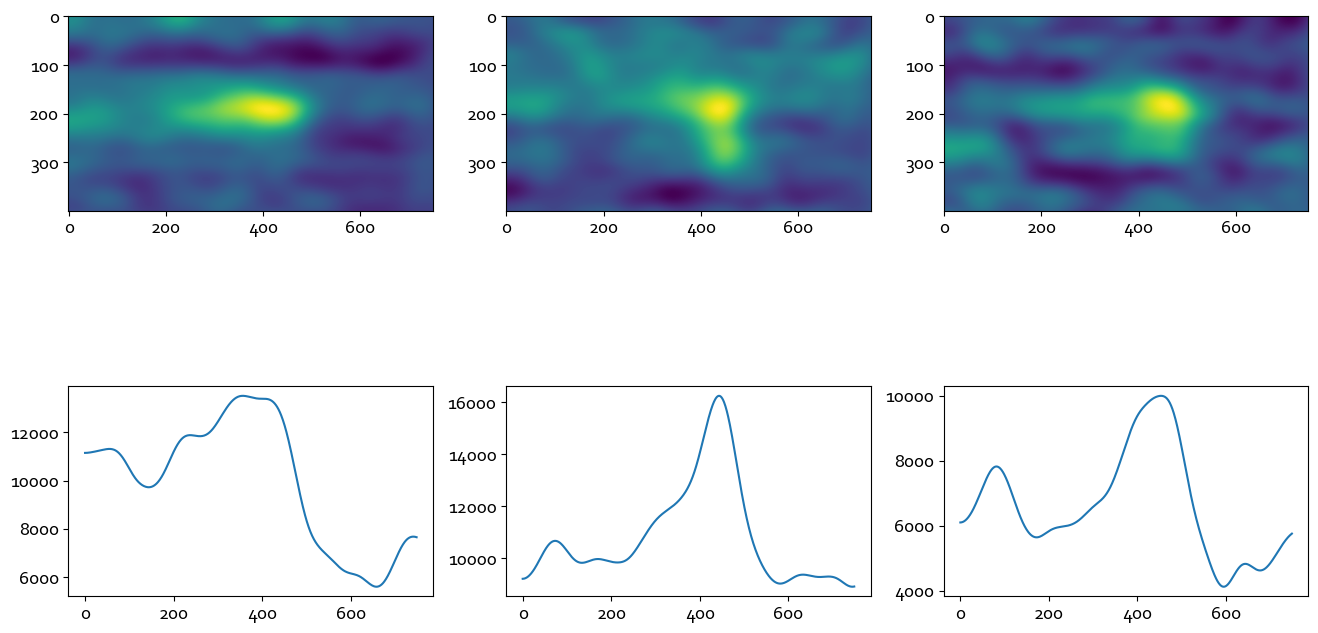

In [ ]:
cProfile.run("this_cell_with_dip()")

rows 0 and 1, col 0
gf sub has 0.0 to 14834.77558449794
rows 0 and 1, col 1
gf sub has 0.0 to 15693.161203645916
rows 0 and 1, col 2
gf sub has 0.0 to 10267.80608633376
         194934 function calls (192633 primitive calls) in 3.182 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.012    0.012    3.181    3.181 808871177.py:71(this_cell_with_gaussian_filter)
        1    0.000    0.000    0.000    0.000 808871177.py:74(<listcomp>)
        9    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(all)
       99    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(any)
       39    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(broadcast_arrays)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(can_cast)
       51    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(column_stack)
      135    0.000    0.000   

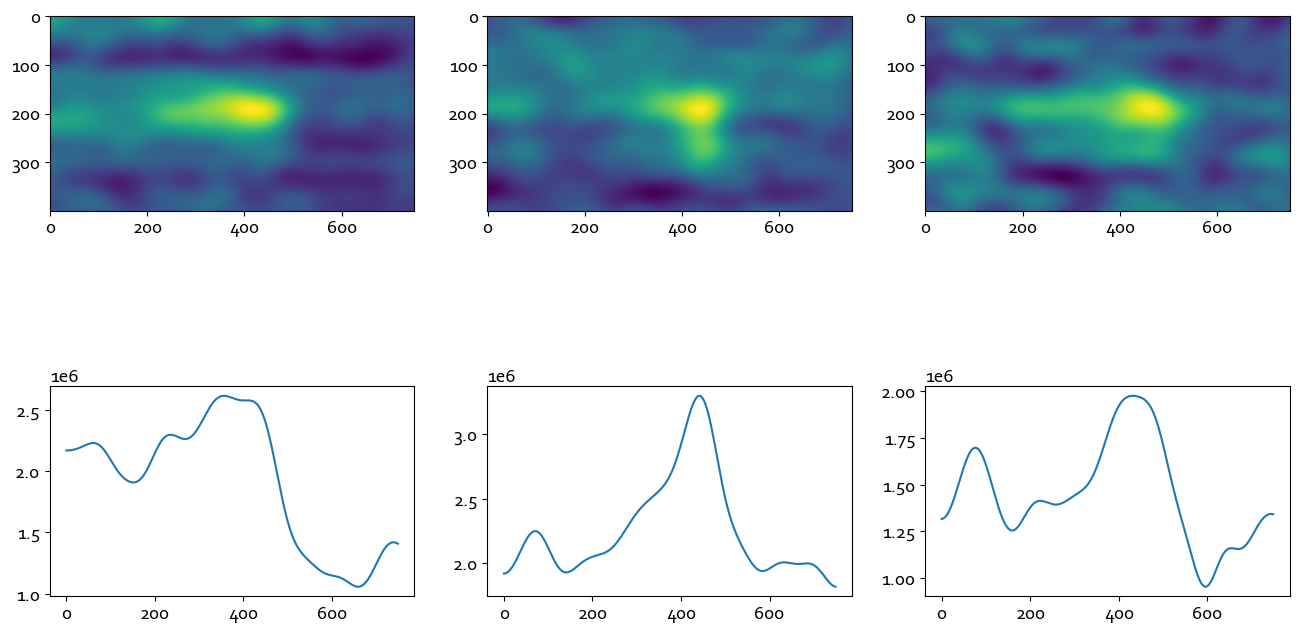

In [ ]:
cProfile.run("this_cell_with_gaussian_filter()")

rows 0 and 1, col 0
rows 0 and 1, col 1
rows 0 and 1, col 2
         194440 function calls (192267 primitive calls) in 129.274 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.013    0.013  129.274  129.274 808871177.py:125(this_cell_with_conv2d)
        1    0.000    0.000    0.000    0.000 808871177.py:130(<listcomp>)
        9    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(all)
       99    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(any)
       39    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(broadcast_arrays)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:177(can_cast)
       51    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(column_stack)
      135    0.000    0.000    0.001    0.000 <__array_function__ internals>:177(concatenate)
       36    0.000    0.000    0.000    0.000 <__a

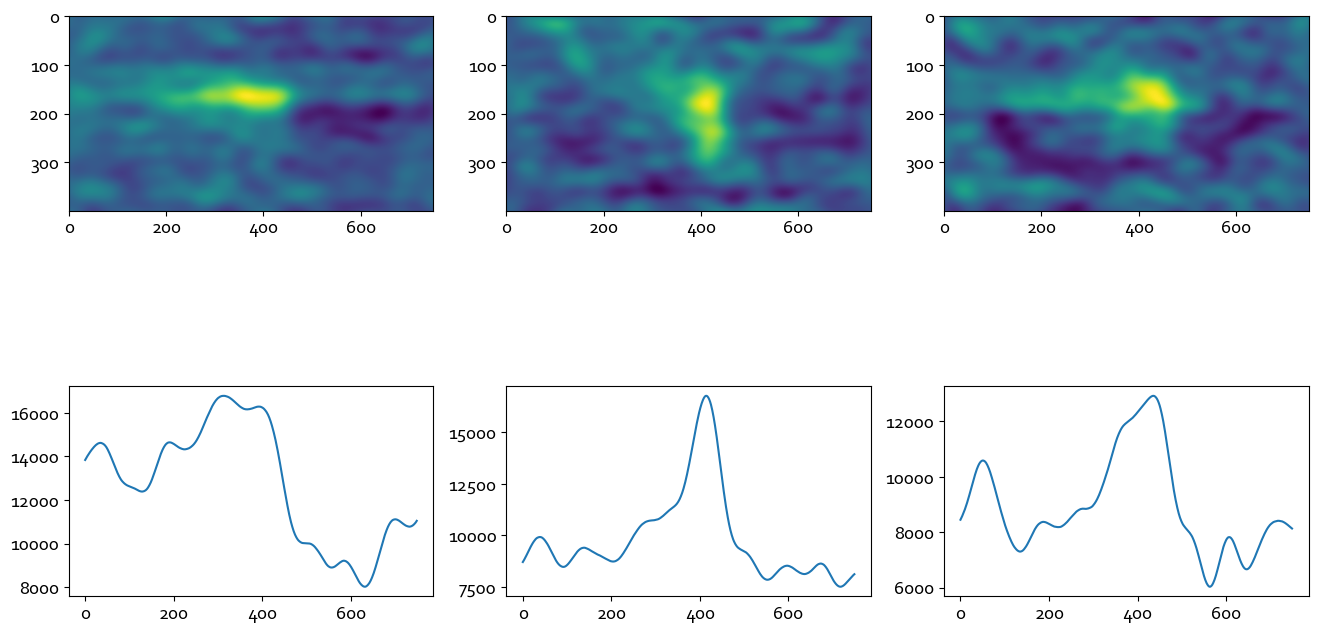

In [ ]:
cProfile.run("this_cell_with_conv2d()")

# read and plot csv files





886
D:/Bunker C/Undulator_Masters_Project/DATA/EXPORTED/23-03-23\15_run004-03232023185238-2420_lineout.csv
D:/Bunker C/Undulator_Masters_Project/DATA/EXPORTED/23-03-23\183_run004-03232023191455-3748_lineout.csv
D:/Bunker C/Undulator_Masters_Project/DATA/EXPORTED/23-03-23\207_run004-03232023191700-3873_lineout.csv
D:/Bunker C/Undulator_Masters_Project/DATA/EXPORTED/23-03-23\48_run004-03232023185637-2654_lineout.csv
D:/Bunker C/Undulator_Masters_Project/DATA/EXPORTED/23-03-23\94_run004-03232023190301-3038_lineout.csv
886
all peaks 886 mean 129.86365765160363
mid peaks 881 mean 130.37887500404676
low peaks 306 mean 53.131999734750785
341
D:/Bunker C/Undulator_Masters_Project/DATA/EXPORTED/23-03-24\170_run005-03242023180014-3986_lineout.csv
D:/Bunker C/Undulator_Masters_Project/DATA/EXPORTED/23-03-24\87_run005-03242023171153-1103_lineout.csv
341
all peaks 341 mean 102.06503101941844
mid peaks 339 mean 102.45383349993091
low peaks 167 mean 55.95929513334759
119
D:/Bunker C/Undulator_Masters

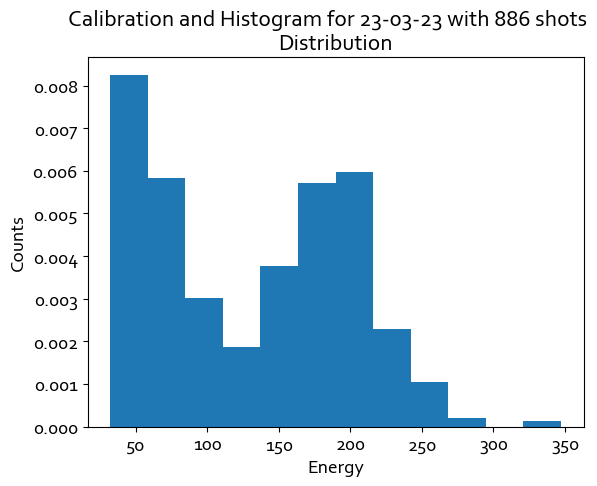

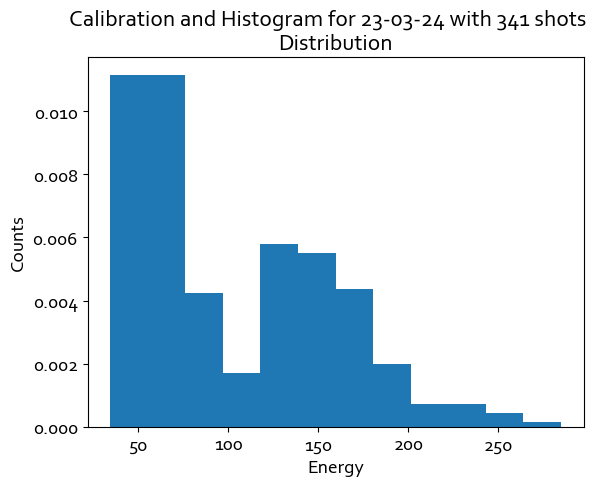

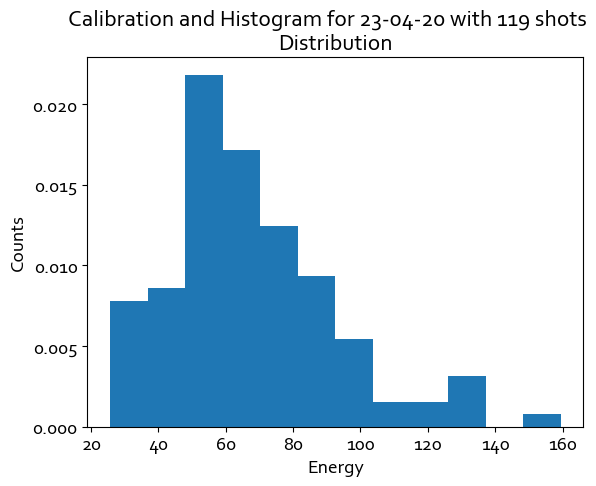

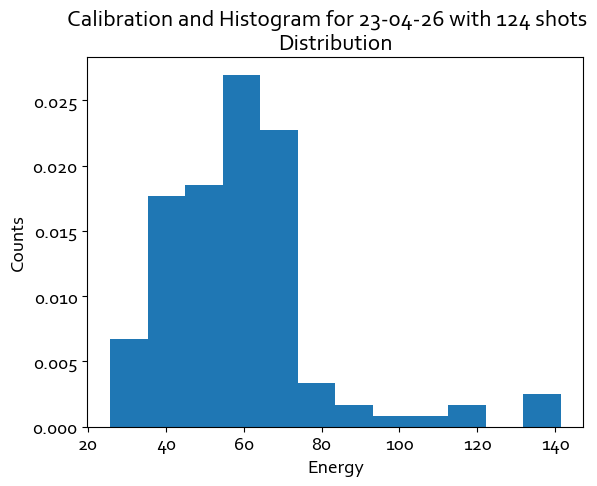

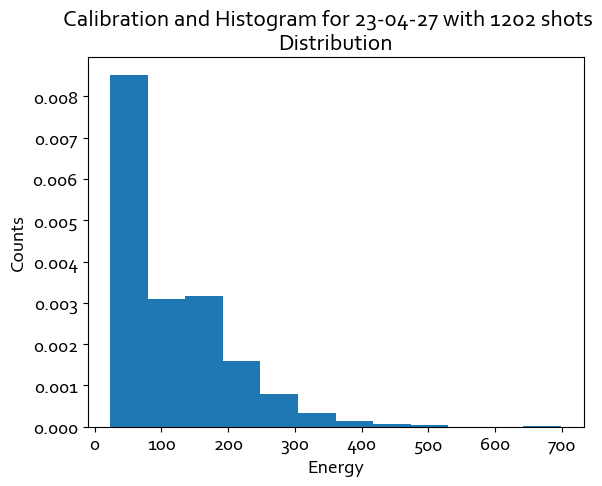

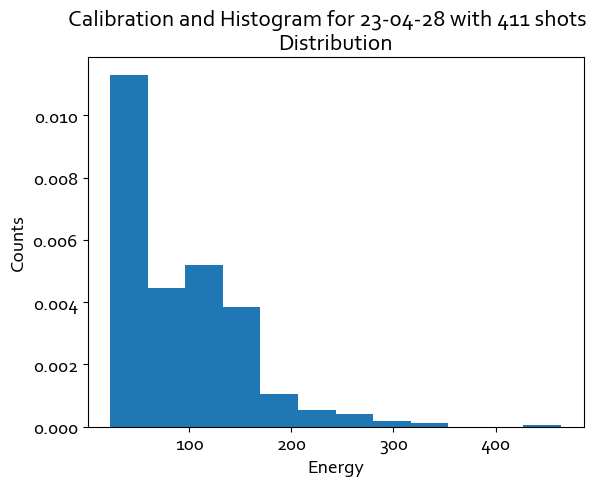

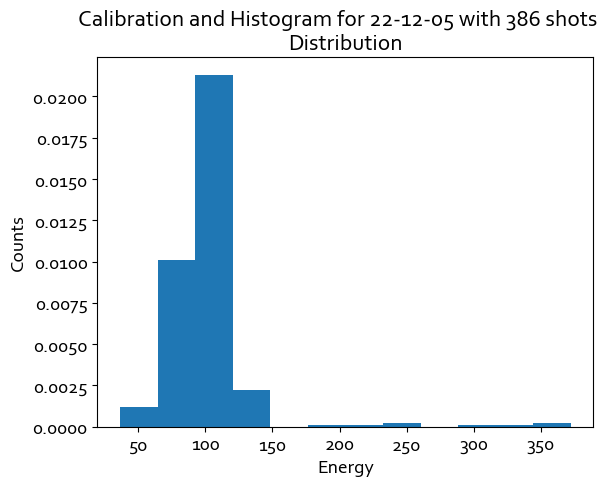

In [10]:

days = ['23-03-23',
        '23-03-24',
        '23-04-20',
        '23-04-26',
        '23-04-27',
        '23-04-28',
        '22-12-05']

for day in days:
 #day = days[1] # "23-03-24"
    if day == '22-12-05': 
        folder = "D:\\Bunker C\\2022\\Dec 05\\Pointing Lanex\\Run005\\HE\\" 
    else: 
        folder = "D:/Bunker C/Undulator_Masters_Project/DATA"
    csv_folder = f"{folder}/EXPORTED/{day}"
    low_peaks = []
    peaks = []
    mid_peaks = []
    e_threshold = 80 # MeV

    csvs = walkDir(csv_folder,select_strings=['.csv'],ignore_strings=[])
    print(len(csvs))
    for file in csvs:
        with open(file) as f:
            e_x = []
            q_x = []
            skiplines = 1
            i=0
            for line in f.readlines():
                if i < skiplines: pass
                else:
                    try:
                        e, q = line.split(",")
                        e_x.append(float(e))
                        q_x.append(float(q))
                    except:
                        if line == "\n": # saved some files with alternating empty lines
                            pass
                        else:
                            print(line)
                            raise ValueError
                i+=1
            peak_ind = np.argmax(q_x)
            peak = e_x[peak_ind]
            edge_threshold = 50
            if peak_ind > len(e_x)-edge_threshold or peak_ind < edge_threshold:
                print(file)
                peaks.append(peak)
                mid_peak_ind = edge_threshold + np.argmax(q_x[edge_threshold:-edge_threshold])
                mid_peak = e_x[mid_peak_ind]
            else:
                peaks.append(peak)
                mid_peaks.append(peak)
            if peak < e_threshold:
                low_peaks.append(peak)
    print(len(peaks))


    histfig, histax = plt.subplots(1,1)
    histfig.suptitle("Calibration and Histogram for {} with {} shots".format(day,len(peaks)))
    histax.set_title("Distribution")
    histax.set_xlabel("Energy")
    histax.set_ylabel("Counts")
    histax.hist(mid_peaks,12,density=True)
        

    print(f"all peaks {len(peaks)} mean {np.mean(peaks)}")
    print(f"mid peaks {len(mid_peaks)} mean {np.mean(mid_peaks)}")
    print(f"low peaks {len(low_peaks)} mean {np.mean(low_peaks)}")
